## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/GradientDomainFunction/cs445_proj3_starter_code3/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

## Part 1 Toy Problem (20 pts)

In [ ]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2

    :param toy_img: numpy.ndarray
    """
    # Rows, columns, im2var
    r, c = img.shape
    im2var = np.arange(r*c).reshape(r, c)
    # Take the gradients of row, row+1 and col,col+1 (2*r*c gradients). Skip last row and col. Extra equation for objective 3
    neq = 1 + 2*r*c - r - c

    # Set up our matrices
    A = scipy.sparse.lil_matrix((neq, r*c), dtype='double')
    b = np.zeros((neq, 1), dtype='double')

    # Equation counter, Obj 3 (minimize start)
    e = 0
    A[e, im2var[0, 0]] = 1
    b[e] = img[0, 0]

    # Obj 1 (exclude last column)
    for i in range(r):
      for j in range(c - 1):
        e += 1
        A[e, im2var[i, j+1]] = 1
        A[e, im2var[i, j]] = -1
        b[e] = img[i, j+1] - img[i, j]

    # Obj 2 (exclude last row)
    for i in range(r - 1):
      for j in range(c):
        e += 1
        A[e, im2var[i+1, j]] = 1
        A[e, im2var[i, j]] = -1
        b[e] = img[i+1, j] - img[i, j]

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=1e-8, btol=1e-8)[0]
    return v.reshape(r, c)

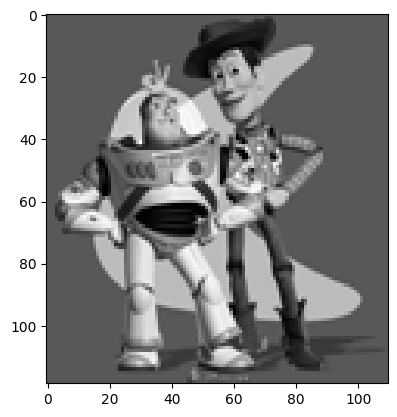

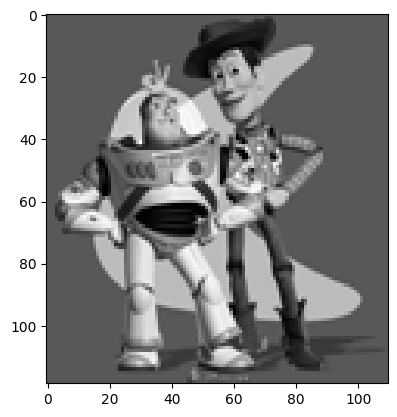

Max error is:  8.073677303210847e-06


In [ ]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

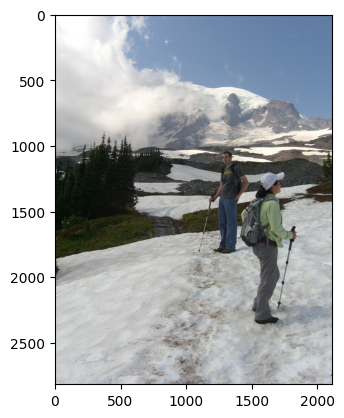

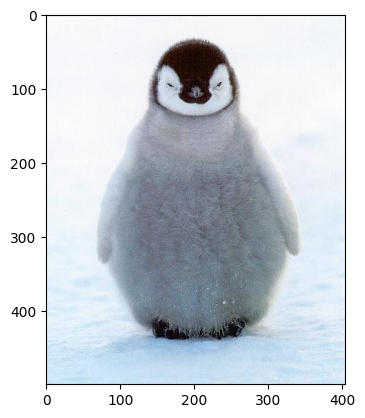

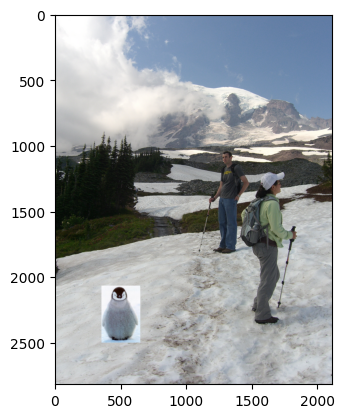

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)

In [ ]:
if use_interface:
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [ ]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param bg_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    # Size of our object image
    r, c = object_img.shape
    # Get x and y coords of where (0, 0) of object_img will be placed in bg_img
    xPos, yPos = bg_ul
    # Patch we are going to replace in bg image
    patch = bg_img[xPos:xPos + r, yPos:yPos + c]

    # Set up im2var
    im2var = np.arange(r*c).reshape(r, c)

    # Take the gradients of row, row+1 and col,col+1 (2*r*c gradients). Skip last row and col
    neq = 2*r*c - r - c

    # Set up our matrices and equation counter
    A = scipy.sparse.lil_matrix((neq, r*c), dtype='double')
    b = np.zeros((neq, 1), dtype='double')
    e = 0

    # Obj 1 (exclude last column)
    for i in range(r):
      for j in range(c - 1):
        # If it is in our mask and equals 1, we need 2 equations
        if(object_mask[i][j] and object_mask[i][j+1] and object_mask[i][j] == 1):
          A[e, im2var[i, j+1]] = 1
          A[e, im2var[i, j]] = -1
          b[e] = object_img[i, j+1] - object_img[i, j]
        else:
          A[e, im2var[i, j+1]] = 1
          b[e] = object_img[i, j+1] - object_img[i, j] + patch[i, j]
        e += 1

    # Obj 2 (exclude last row)
    for i in range(r - 1):
      for j in range(c):
        # If it is in our mask, we need 2 equations
        if(object_mask[i][j] and object_mask[i+1][j] and object_mask[i][j] == 1):
          A[e, im2var[i+1, j]] = 1
          A[e, im2var[i, j]] = -1
          b[e] = object_img[i+1, j] - object_img[i, j]
        else:
          A[e, im2var[i+1, j]] = 1
          b[e] = object_img[i+1, j] - object_img[i, j] + patch[i, j]
        e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=1e-8, btol=1e-8)[0].reshape(r, c)
    bg_img[xPos:xPos + r, yPos:yPos + c] = v
    return bg_img

In [ ]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

Output hidden; open in https://colab.research.google.com to view.

<Figure size 640x480 with 0 Axes>

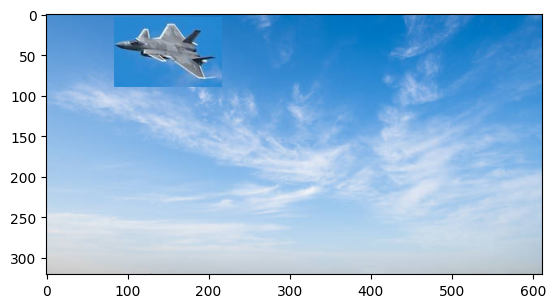

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/sky.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
object_img = cv2.cvtColor(cv2.imread('samples/jet.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (5, 140, 140, 5)
  ys = (5, 5, 90, 90)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (150, 90) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

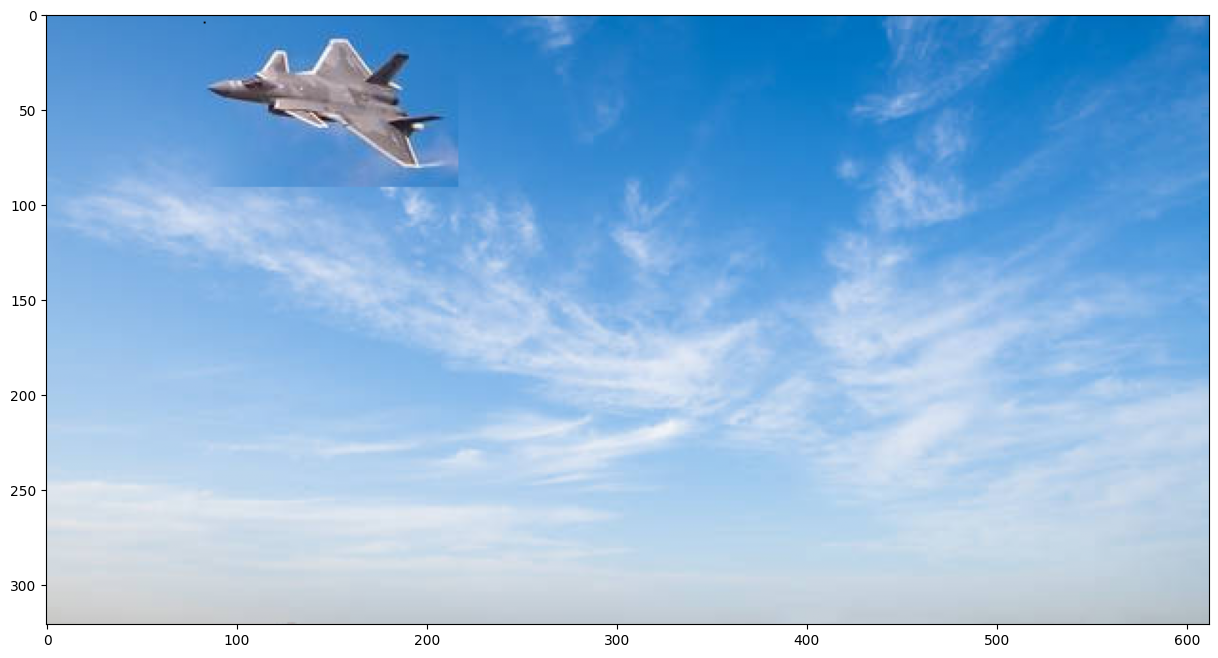

In [ ]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

<Figure size 640x480 with 0 Axes>

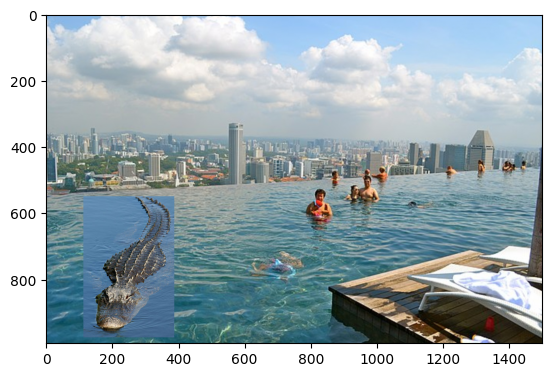

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/pool.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
object_img = cv2.cvtColor(cv2.imread('samples/alligator.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (85, 359, 359, 85)
  ys = (75, 75, 500, 500)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (250, 975) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

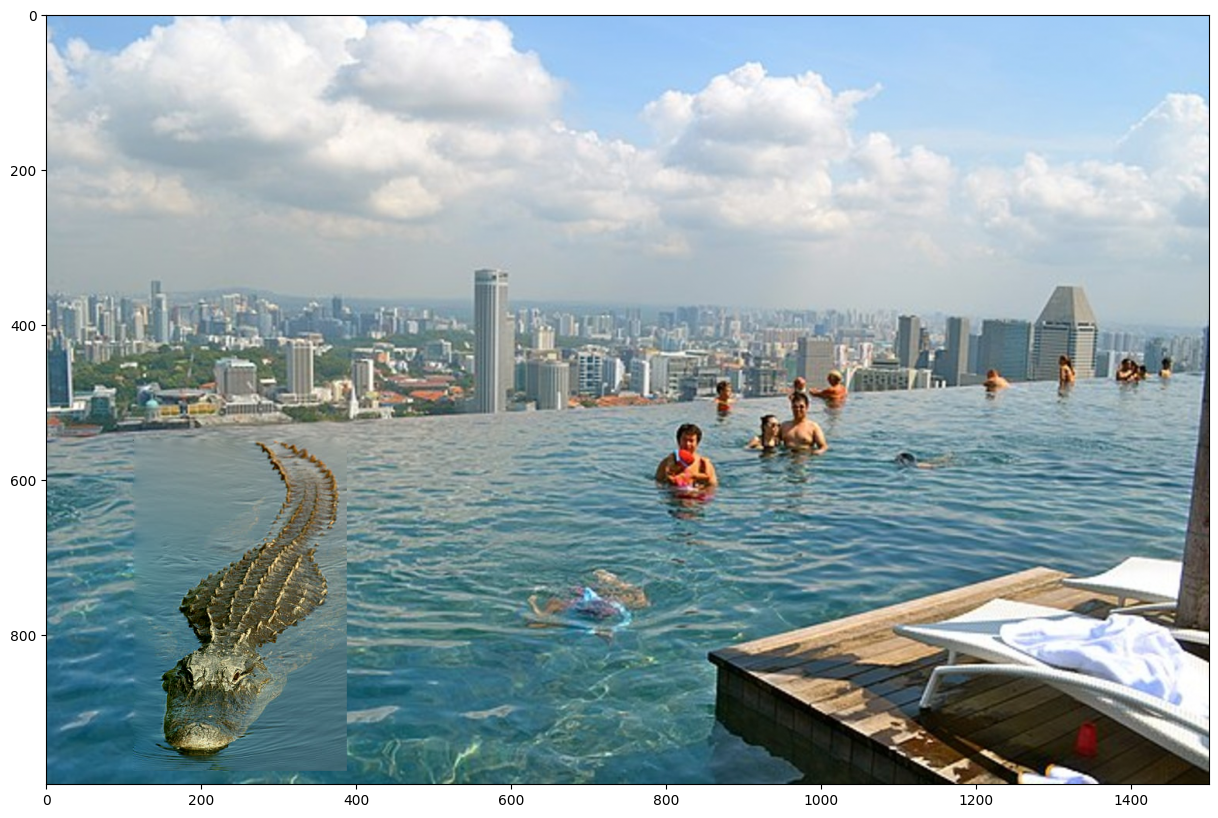

In [ ]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    # Size of our object image
    r, c = object_img.shape
    # Get x and y coords of where (0, 0) of object_img will be placed in bg_img
    xPos, yPos = bg_ul
    # Patch we are going to replace in bg image
    patch = bg_img[xPos:xPos + r, yPos:yPos + c]

    # Set up im2var
    im2var = np.arange(r*c).reshape(r, c)

    # Take the gradients of row, row+1 and col,col+1 (2*r*c gradients). Skip last row and col
    neq = 2*r*c - r - c

    # Set up our matrices and equation counter
    A = scipy.sparse.lil_matrix((neq, r*c), dtype='double')
    b = np.zeros((neq, 1), dtype='double')
    e = 0

    # Obj 1 (exclude last column)
    for i in range(r):
      for j in range(c - 1):
        # If it is in our mask and equals 1, we need 2 equations
        if(object_mask[i][j] and object_mask[i][j+1] and object_mask[i][j] == 1):
          A[e, im2var[i, j+1]] = 1
          A[e, im2var[i, j]] = -1
          diff1 = object_img[i, j+1] - object_img[i, j]
          diff2 = patch[i, j+1] - patch[i, j]
          if(abs(diff1) > abs(diff2)): b[e] = diff1
          else: b[e] = diff2
        else:
          A[e, im2var[i, j+1]] = 1
          b[e] = object_img[i, j+1] - object_img[i, j] + patch[i, j]
        e += 1

    # Obj 2 (exclude last row)
    for i in range(r - 1):
      for j in range(c):
        # If it is in our mask, we need 2 equations
        if(object_mask[i][j] and object_mask[i+1][j] and object_mask[i][j] == 1):
          A[e, im2var[i+1, j]] = 1
          A[e, im2var[i, j]] = -1
          diff1 = object_img[i+1, j] - object_img[i, j]
          diff2 = patch[i+1, j] - patch[i, j]
          if(abs(diff1) > abs(diff2)): b[e] = diff1
          else: b[e] = diff2
        else:
          A[e, im2var[i+1, j]] = 1
          b[e] = object_img[i+1, j] - object_img[i, j] + patch[i, j]
        e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=1e-8, btol=1e-8)[0].reshape(r, c)
    bg_img[xPos:xPos + r, yPos:yPos + c] = v
    return bg_img



<Figure size 640x480 with 0 Axes>

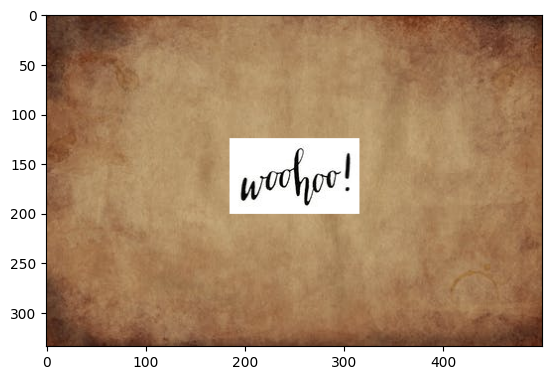

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/background.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
object_img = cv2.cvtColor(cv2.imread('samples/writing.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (55, 185, 185, 55)
  ys = (75, 75, 150, 150)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (250, 200) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

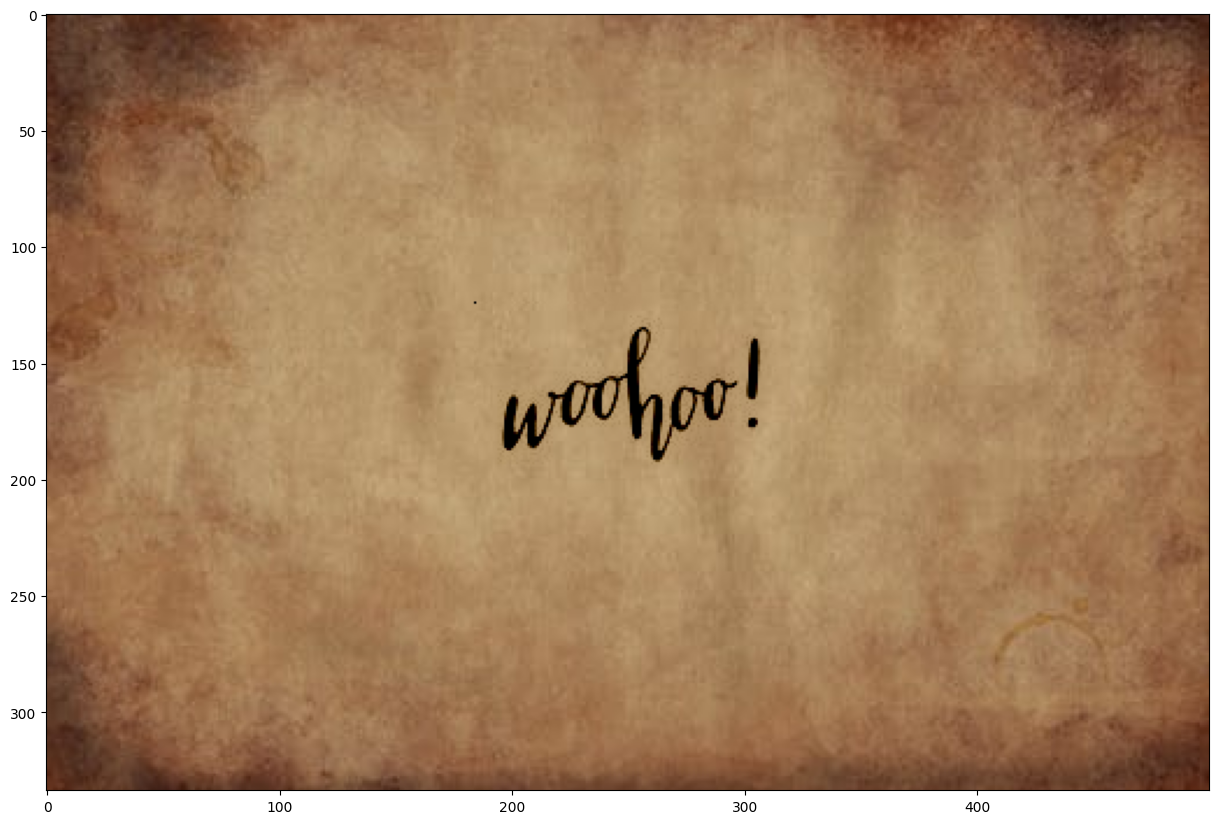

In [ ]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)